# Descripción corta del challenge

Se van a estudiar las predicciones que realiza un software (COMPAS) sobre si un persona que ha cometido un delito tiene riesgo de reincidencia o no. Queremos cercionarnos de que no hay un sesgo hacia ningún grupo específico de la población en las predicciones de este software. Lo haremos comparando, para un conjunto de individuos, datos sobre las predicciones del software, y datos sobre si realmente esas personas acabaron reincidiendo o no.

Para ello, 
- Se realizará un análisis exploratorio de datos, se depurarán los mismos y se descubrirán patrones interesantes
- Se definirá un clasificador para poder comparar de forma justa los datos de las predicciones con los datos reales.
- Se analizarán las matrices de confusión desde diferentes perspectivas, para averiguar si hay sesgo en el software de predicción hacia algún subgrupo de la población

# Contexto
Cada día es más frecuente la introducción de la ciencia de datos en el ámbito del derecho y la justicia.

Un ejemplo bien conocido de ello es el sistema COMPAS (Correctional offender management profiling for alternative sanctions) que se usa en varios estados de los Estados Unidos para hacer una evaluación del riesgo de reincidencia de las personas detenidas.

Una breve descripción del sistema puede verse en la página https://en.wikipedia.org/wiki/COMPAS_(software).

En este caso, proporciona un conjunto de datos en bruto con información de las evaluaciones (fichero compas-scores.csv) y la historia legal de unos 11 000 casos en los años 2013 y 2014 (se trata de uno de los ficheros originales utilizados en un análisis independiente del sistema COMPAS llevado a cabo por ProPublica, disponible en internet).

URL del análisis de ProPublica: https://github.com/propublica/compas-analysis/

Aunque el conjunto de datos contiene información adicional, para resolver las cuestiones planteadas en este caso son necesarios (aparte de algunos campos cuyo nombre es autoexplicativo) los siguientes campos:
- “compas_screening_date”: se refiere a la fecha en la que se realizó la evaluación
- “decile_score”: es un número, de 1 a 10 que indica el riesgo de reincidencia en general (a mayor riesgo, mayor número).
- “v_decile_score”: es un número de 1 a 10, potencialmente distinto del anterior, que indica el riesgo de reincidencia en delitos violentos. Al hacer la evaluación de un caso en COMPAS, se generan las dos puntuaciones (entre otras cosas).
- “is_recid”: indicación de si la persona es reincidente (en el tiempo en que se recogen datos: no hay información de si la persona es reincidente más allá de ciertas fechas, y es importante tener esto en cuenta para asegurarse de hacer comparaciones homogéneas).
- “r_offense_date”: fecha en la que se cometió el delito por el que se considera reincidente a la persona.
- “is_violent_recid”: indicación de si la persona es reincidente en un delito con violencia (las mismas consideraciones sobre fechas que para “is_recid” aplican aquí)".
- “vr_offense_date”: fecha en la que se cometió el delito violento que da lugar a la consideración de reincidente.

# Se pide
1. Cargar los datos y realizar un análisis exploratorio y una evaluación de la calidad de los datos necesarios para el resto del caso. Específicamente, evaluar la integridad, validez y actualidad de los datos y proponer estrategias de mitigación de los posibles problemas encontrados.
2. ¿Son los campos “is_recid” e “is_violent_recid” en este conjunto de datos adecuados para evaluar la precisión de las estimaciones de riesgo generadas por el sistema COMPAS? Si no es así, definir y calcular una feature que sí lo sea.
3. El umbral para establecer medidas preventivas de la reincidencia es de 7 en adelante. Dado este umbral, generar una tabla de contingencia, explicando qué caso se considera como “positivo” (y, por lo tanto, cuáles son los errores de tipo I y los errores de tipo II).
4. El sistema asigna, de media, evaluaciones de riesgo más altas a los hombres que a las mujeres, y a las personas de raza afroamericana que a las de raza caucásica. Sin embargo, también las tasas de reincidencia son más altas para esos colectivos, aunque no está claro que la asignación de riesgo sea “justa” o no. Mostrar estas diferencias mediante representaciones gráficas y utilizarlas para analizar si la asignación de evaluaciones es justa o no.
5. ¿Para qué tipo de riesgos, el de delitos generales o el de delitos violentos, tiene el sistema más capacidad predictiva?

 # RESOLUCIÓN

## Punto 1
**Cargar los datos y realizar un análisis exploratorio y una evaluación de la calidad de los datos necesarios para el resto del caso. Específicamente, evaluar la integridad, validez y actualidad de los datos y proponer estrategias de mitigación de los posibles problemas encontrados.**

### Transformaciones iniciales

En primer lugar, vamos a cargar los datos y hacer varias transformaciones preliminares sobre el dataframe:

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Cargamos el fichero

historiales_raw = pd.read_csv('compas-scores.csv', sep=',')

In [3]:
historiales_raw.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,NaN,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,NaN,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,NaN,NaN,Risk of Violence,3,Low,2013-04-14,Risk of Recidivism,4,Low,2013-04-14
4,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,NaN,NaN,Risk of Violence,6,Medium,2013-01-13,Risk of Recidivism,8,High,2013-01-13


In [4]:
historiales_raw.columns.values

array(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex',
       'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_case_number', 'c_offense_date', 'c_arrest_date',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc',
       'is_recid', 'num_r_cases', 'r_case_number', 'r_charge_degree',
       'r_days_from_arrest', 'r_offense_date', 'r_charge_desc',
       'r_jail_in', 'r_jail_out', 'is_violent_recid', 'num_vr_cases',
       'vr_case_number', 'vr_charge_degree', 'vr_offense_date',
       'vr_charge_desc', 'v_type_of_assessment', 'v_decile_score',
       'v_score_text', 'v_screening_date', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date'], dtype=object)

Se consulta la documentación disponible sobre el estudio de ProPublica (https://github.com/propublica/compas-analysis/) para indagar más acerca del significado de cada una de las 47 variables. El conjunto de variables es muy extenso, y muchas de ellas están asociadas a conceptos propios del dominio que estamos estudiando (legal, criminalidad), se podría estar analizando horas y horas este dataset.

Por razones de simplicidad, en adelante se trabajará sólo con determinadas columnas del dataframe: se han escogido las columnas que, o bien ya se nos ha indicado en el enunciado de este ejercicio que son clave, o bien pueden ayudar a detectar errores de calidad de datos, aún siendo un profano en el dominio que se estudia.

In [5]:
# Definimos las columnas a utilizar, generamos un nuevo dataframe sólo con esas columnas

utilizar_columnas = ['name', 'sex', 'race', 'age', 'dob', 'compas_screening_date', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'r_offense_date', 'v_decile_score', 'is_violent_recid', 'vr_offense_date']
historiales = historiales_raw[utilizar_columnas].copy()
  
# Reordenamos las columnas para que la visualización de datos resulte más clara (primero las columnas relacionadas con delitos no violentos, después las
# relacionadas con delitos violentos)

historiales = historiales.reindex(columns=utilizar_columnas)

In [6]:
# Convertimos a categóricas las variables que lo sean

var_cat = ['sex', 'race']
historiales[var_cat] = historiales[var_cat].astype('category')

In [7]:
# Convertimos a fecha las variables que lo sean

var_fecha = ['dob', 'compas_screening_date', 'r_offense_date', 'vr_offense_date']
historiales[var_fecha ] = historiales[var_fecha ].astype('datetime64[ns]')

In [8]:
historiales

,name,sex,race,age,dob,compas_screening_date,days_b_screening_arrest,decile_score,is_recid,r_offense_date,v_decile_score,is_violent_recid,vr_offense_date
0,miguel hernandez,Male,Other,69,1947-04-18,2013-08-14,-1.0,1,0,NaT,1,0,NaT
1,michael ryan,Male,Caucasian,31,1985-02-06,2014-12-31,NaN,5,-1,NaT,2,0,NaT
2,kevon dixon,Male,African-American,34,1982-01-22,2013-01-27,-1.0,3,1,2013-07-05,1,1,2013-07-05
3,ed philo,Male,African-American,24,1991-05-14,2013-04-14,-1.0,4,1,2013-06-16,3,0,NaT
4,marcu brown,Male,African-American,23,1993-01-21,2013-01-13,NaN,8,0,NaT,6,0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11752,patrick hamilton,Male,Other,47,1968-05-02,2013-09-22,-1.0,3,0,NaT,1,0,NaT
11753,raymond hernandez,Male,Caucasian,22,1993-06-24,2013-05-17,-1.0,7,1,2014-10-11,5,0,NaT
11754,dieuseul pierre-gilles,Male,Other,35,1981-01-24,2014-10-08,NaN,4,0,NaT,3,0,NaT
11755,scott lomagistro,Male,Caucasian,29,1986-12-04,2013-12-03,-196.0,3,0,NaT,2,0,NaT


In [9]:
historiales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   name                     11757 non-null  object        
 1   sex                      11757 non-null  category      
 2   race                     11757 non-null  category      
 3   age                      11757 non-null  int64         
 4   dob                      11757 non-null  datetime64[ns]
 5   compas_screening_date    11757 non-null  datetime64[ns]
 6   days_b_screening_arrest  10577 non-null  float64       
 7   decile_score             11757 non-null  int64         
 8   is_recid                 11757 non-null  int64         
 9   r_offense_date           3703 non-null   datetime64[ns]
 10  v_decile_score           11757 non-null  int64         
 11  is_violent_recid         11757 non-null  int64         
 12  vr_offense_date          882 non

### Análisis exploratorio, evaluación de calidad de los datos, aumento de su calidad

Una comprobación muy sencilla en primera instancia: detectar si hay duplicados o no

In [10]:
historiales.duplicated().sum()

0

Ahora, vamos a analizar columna por columna los datos que disponemos

In [11]:
# Definimos una sencilla función para ver algunos de los indicadores más relevantes de cada columna del dataframe

def describe_columna(df, col):
    print(f'Columna: {col}  -  Tipo de datos: {df[col].dtype}')
    print(f'Número de valores nulos: {df[col].isnull().sum()}')
    print('\nFunción describe():\n')
    print(df[col].describe())

Columna 'name'

In [12]:
describe_columna(historiales,'name')

Columna: name  -  Tipo de datos: object
Número de valores nulos: 0

Función describe():

count          11757
unique         11584
top       john brown
freq               4
Name: name, dtype: object


In [13]:
# Vemos que hay nombres duplicados. En primera instancia, vamos a ver de cuántos registros se trata
# También vamos a ver los nombres más repetidos, probablemente se trate simplemente de nombres que son muy comunes

print(historiales.name.duplicated(keep=False).sum())
print()
print(historiales[historiales.name.duplicated(keep=False)]['name'].value_counts().head(10))

328

carlos vasquez        4
john brown            4
michael cunningham    4
robert taylor         4
gregory williams      3
james brown           3
travis wilson         3
james williams        3
james smith           3
steven wilson         3
Name: name, dtype: int64


In [14]:
# Parecen nombres bastante comunes, pero vamos a analizar esta cuestión con un poco más de detalle.
# Vamos a ver si los nombres duplicados tienen fecha de nacimiento coincidente

historiales[historiales.name.duplicated(keep=False)].groupby(['name','dob']).count()['sex'].sort_values(ascending=False).where(lambda x : x>1).dropna()

name               dob       
alejandro cabrera  1990-03-30    2.0
gueslly deravine   1989-11-30    2.0
scott botkin       1969-10-05    2.0
Name: sex, dtype: float64

In [15]:
# Analizamos estos casos en particular

nombres_dup = historiales[historiales.name.duplicated(keep=False)].groupby(['name','dob']).count()['sex'].sort_values(ascending=False).where(lambda x : x>1).dropna().reset_index()['name'].to_list()
historiales[historiales['name'].isin(nombres_dup)].sort_values(by='name')

,name,sex,race,age,dob,compas_screening_date,days_b_screening_arrest,decile_score,is_recid,r_offense_date,v_decile_score,is_violent_recid,vr_offense_date
6536,alejandro cabrera,Male,Caucasian,26,1990-03-30,2013-09-23,0.0,4,1,2013-10-06,3,1,2013-10-06
11585,alejandro cabrera,Male,Hispanic,26,1990-03-30,2013-10-07,NaN,4,-1,NaT,3,0,NaT
604,gueslly deravine,Male,African-American,26,1989-11-30,2013-03-27,-34.0,7,0,NaT,7,0,NaT
3761,gueslly deravine,Male,African-American,26,1989-11-30,2013-02-21,NaN,5,-1,NaT,6,0,NaT
3701,scott botkin,Male,Caucasian,46,1969-10-05,2013-02-08,0.0,8,1,2014-01-04,3,0,NaT
9956,scott botkin,Male,Caucasian,46,1969-10-05,2013-06-18,NaN,3,-1,NaT,2,0,NaT


In [16]:
# Quizá sea la misma persona, pero con dos arrestos, en fechas diferentes. Para el tipo de análisis que queremos hacer 
# (básicamente, evaluar si el sistema COMPAS es justo con las personas, en concreto con ciertos colectivos), no tiene sentido
# mantener registros duplicados. Los vamos a eliminar

historiales = historiales[~historiales['name'].isin(nombres_dup)]

Columna 'sex'

In [17]:
describe_columna(historiales,'sex')

Columna: sex  -  Tipo de datos: category
Número de valores nulos: 0

Función describe():

count     11751
unique        2
top        Male
freq       9330
Name: sex, dtype: object


In [18]:
historiales.sex.value_counts()

# No se observa ningún problema de calidad de datos

Male      9330
Female    2421
Name: sex, dtype: int64

Columna 'race'

In [19]:
describe_columna(historiales,'race')

Columna: race  -  Tipo de datos: category
Número de valores nulos: 0

Función describe():

count                11751
unique                   6
top       African-American
freq                  5811
Name: race, dtype: object


In [20]:
historiales.race.value_counts()

# Calidad de datos ok

African-American    5811
Caucasian           4082
Hispanic            1099
Other                661
Asian                 58
Native American       40
Name: race, dtype: int64

Columna 'age' 

In [21]:
print(describe_columna(historiales,'age'))

Columna: age  -  Tipo de datos: int64
Número de valores nulos: 0

Función describe():

count    11751.000000
mean        35.144583
std         12.023945
min         18.000000
25%         25.000000
50%         32.000000
75%         43.000000
max         96.000000
Name: age, dtype: float64
None


In [22]:
# Vamos a revisar las edades más altas, si hay muchos registros de nonagenarios podríamos considerar problemas de calidad de datos.

historiales['age'].sort_values(ascending=False).head(10)
# No parece que haya problemas

3988     96
11206    86
1214     83
6404     83
7471     80
9011     79
6436     78
267      78
11311    78
2694     77
Name: age, dtype: int64

Columna 'days_b_screening_arrest'

In [23]:
describe_columna(historiales,'days_b_screening_arrest')

Columna: days_b_screening_arrest  -  Tipo de datos: float64
Número de valores nulos: 1177

Función describe():

count    10574.000000
mean        -0.875071
std         72.898925
min       -597.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       1057.000000
Name: days_b_screening_arrest, dtype: float64


Esta columna representa la diferencia de días para un individuo, entre el día que fue arrestado al cometer un delito ('c_jail_in') y el día que se le hizo la evaluación COMPAS ('compas_screening_date'). Cuando leí la documentación de ProPublica, me di cuenta de que mencionan explícitamente que, cuando hay una diferencia muy acusada entre ambas fechas, se sospecha que hay un problema de calidad de datos y los registros correspondientes deben desecharse:

Citas textuales:
_"It was not always clear, however, which criminal case was associated with an individual’s COMPAS score. To match COMPAS scores with accompanying cases, we considered cases with arrest dates or charge dates within 30 days of a COMPAS assessment being conducted. In some instances, we could not find any corresponding charges to COMPAS scores. We removed those cases from our analysis."_

_"If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense._"

Visto esto, parece razonable hacer lo mismo que ha hecho ProPublica, descartar los casos en los que la diferencia de fechas excede los 30 días porque probablemente, en esos casos particulares, no se ha cotejado bien la información de las evaluaciones de COMPAS, con la de los registros criminales del condado de Broward.

In [24]:
# Descartamos los casos con valores 'days_b_screening_arrest' mayores a 30 en valor absoluto. Los valores nulos (aquellos para los que no se puede hacer la diferencia entre la fecha de arresto
# y de evaluación COMPAS porque no se dispone de la fecha de arresto) también son excluidos

historiales = historiales[abs(historiales['days_b_screening_arrest']) <= 30]

Columna 'compas_screening_date'

In [25]:
describe_columna(historiales,'compas_screening_date')

# Vemos que, tal como se nos indica en la documentación de ProPublica, el rango de fechas es exactamente dos años
# No hay nulos, y hay un número de valores únicos cercano al espacio de 2 años (730 días)

Columna: compas_screening_date  -  Tipo de datos: datetime64[ns]
Número de valores nulos: 0

Función describe():

count                    9394
unique                    701
top       2013-04-20 00:00:00
freq                       35
first     2013-01-01 00:00:00
last      2014-12-31 00:00:00
Name: compas_screening_date, dtype: object


<AxesSubplot:xlabel='compas_screening_date', ylabel='Count'>

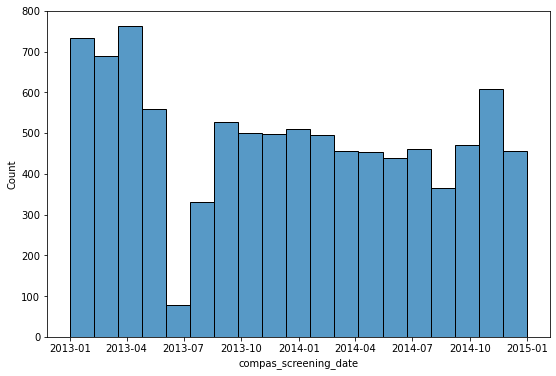

In [26]:
# Para completar la exploración inicial sobre esta variable, vamos a realizar una visualización para ver cómo se distribuyen los casos
# registrados a lo largo de estos dos años

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

fig_dims = (9, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(data=historiales, x="compas_screening_date", ax=ax)

# En general, es una distribución bastante homogénea, llama la atención que a principios de 2013 el número de registros es bastante alto,
# y a mediados de ese año el número de registros baja mucho

Columna 'decile_score'

In [27]:
describe_columna(historiales,'decile_score')

# Llama la atención que hay puntuaciones con valor -1, cuando en la documentación se especifica que las puntuaciones son números enteros del 1 al 10.
# Probablemente se trate de un problema de validez de datos, vamos a ver a cuántos registros afecta

Columna: decile_score  -  Tipo de datos: int64
Número de valores nulos: 0

Función describe():

count    9394.000000
mean        4.300617
std         2.852099
min        -1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        10.000000
Name: decile_score, dtype: float64


In [28]:
# Vemos cuántos valores -1 hay (y de paso nos aseguramos de que no haya valores=0)

historiales['decile_score'].value_counts()

 1     2115
 2     1288
 3     1004
 4      963
 5      835
 6      785
 7      720
 8      613
 9      606
 10     457
-1        8
Name: decile_score, dtype: int64

In [29]:
# Nos quedamos sólo con los registros correctos

historiales = historiales[historiales['decile_score'] >= 1]

<AxesSubplot:xlabel='decile_score', ylabel='Count'>

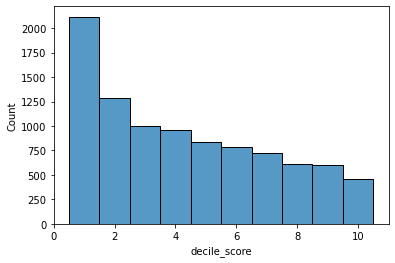

In [30]:
# Finalmente, visualizamos la distribución de puntuaciones para el conjunto de individuos

sns.histplot(data=historiales, x="decile_score", discrete=True)

Columna 'is_recid'

In [31]:
describe_columna(historiales,'is_recid')

# Llama la atención que hay puntuaciones con valor -1, nuevamente apunta a un problema de validez. Revisando la documentación de 
# ProPublica, se encuentra que se asigna este valor cuando para la persona en cuestión no se ha encontrado su registro COMPAS

Columna: is_recid  -  Tipo de datos: int64
Número de valores nulos: 0

Función describe():

count    9386.000000
mean        0.339335
std         0.473734
min        -1.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: is_recid, dtype: float64


In [32]:
# Vemos cuántos valores -1 hay

historiales.is_recid.value_counts()

 0    6199
 1    3186
-1       1
Name: is_recid, dtype: int64

In [33]:
# Nos quedamos sólo con los registros correctos

historiales = historiales[historiales['is_recid'] != -1]

Columna 'r_offense_date'

In [34]:
describe_columna(historiales,'r_offense_date')

# Nos encontramos con una gran cantidad de valores nulos, veamos si es un problema de integridad o no. El número de estos valores nulos 
# coincide exactamente con el número de campos en la columna 'is_recid' que son 0. Lo cual es absolutamente coherente, tenemos valor de 
# la fecha para las personas que han reincidido, y para las demás el campo está vacío

Columna: r_offense_date  -  Tipo de datos: datetime64[ns]
Número de valores nulos: 6199

Función describe():

count                    3186
unique                   1055
top       2014-12-08 00:00:00
freq                       12
first     2013-01-03 00:00:00
last      2016-03-29 00:00:00
Name: r_offense_date, dtype: object


<AxesSubplot:xlabel='r_offense_date', ylabel='Count'>

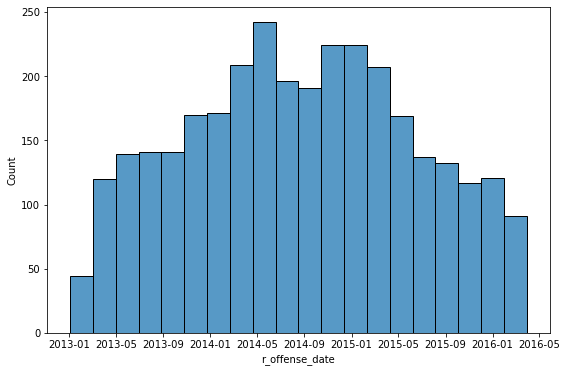

In [35]:
# Al igual que hicimos para la columna 'compas_screening_date', vamos a ver cómo se distribuyen estos valores

fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(data=historiales, x="r_offense_date", ax=ax)

# La forma de la distribución parece lógica, para el rango de fechas en los que se hizo la evaluación COMPAS 
# (años 2013 y 2014, compass screening dates). A principios de 2013 algunos de los que después reincidieron 
# aún no habían siquiera cometido el primer delito, se ahí que haya menos casos en esas fechas. Para las últimas
# fechas que se recogieron registros (Q1 de 2016) ya ha pasado mucho tiempo desde el primer delito, y la mayoría del
# conjunto ya ha reincidido

# En el siguiente punto (2.), se profundizará más en cómo se relacionan estas fechas de reincidencia con las fechas en las
# que se hizo la evaluación COMPAS

Columna 'v_decile_score'

In [36]:
describe_columna(historiales,'v_decile_score')

Columna: v_decile_score  -  Tipo de datos: int64
Número de valores nulos: 0

Función describe():

count    9385.000000
mean        3.545019
std         2.479611
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        10.000000
Name: v_decile_score, dtype: float64


<AxesSubplot:xlabel='v_decile_score', ylabel='Count'>

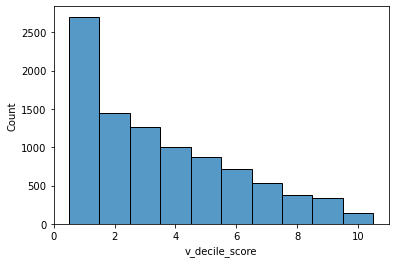

In [37]:
# Distribución de las puntuaciones

sns.histplot(data=historiales, x="v_decile_score", discrete=True)

Columna 'is_violent_recid'

In [38]:
describe_columna(historiales,'is_violent_recid')

Columna: is_violent_recid  -  Tipo de datos: int64
Número de valores nulos: 0

Función describe():

count    9385.000000
mean        0.079275
std         0.270183
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: is_violent_recid, dtype: float64


In [39]:
# Vemos el total de casos violentos registrados, para posteriormente compararlos con el total de fechas de casos violentos registradas

historiales.is_violent_recid.value_counts()

0    8641
1     744
Name: is_violent_recid, dtype: int64

Columna 'vr_offense_date'

In [40]:
describe_columna(historiales,'vr_offense_date')

# Nuevamente, el número de registros de fechas nulas coincide con el número de casos sin reincidencia

Columna: vr_offense_date  -  Tipo de datos: datetime64[ns]
Número de valores nulos: 8641

Función describe():

count                     744
unique                    531
top       2015-08-15 00:00:00
freq                        5
first     2013-01-28 00:00:00
last      2016-03-13 00:00:00
Name: vr_offense_date, dtype: object


<AxesSubplot:xlabel='vr_offense_date', ylabel='Count'>

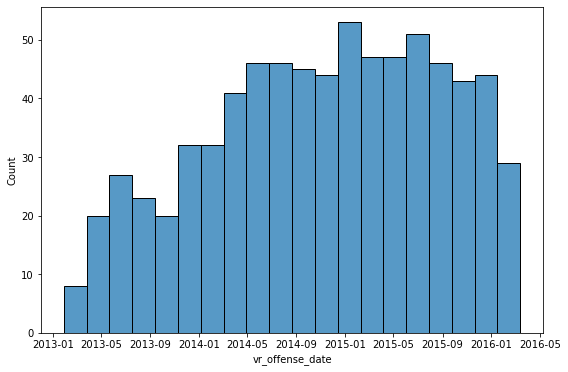

In [41]:
# Al igual que hicimos para la columna 'compas_screening_date', vamos a ver cómo se distribuyen estos valores

fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(data=historiales, x="vr_offense_date", ax=ax, bins=20)

## Punto 2
**¿Son los campos “is_recid” e “is_violent_recid” en este conjunto de datos adecuados para evaluar la precisión de las estimaciones de riesgo generadas por el sistema COMPAS? Si no es así, definir y calcular una feature que sí lo sea.**

Para responder a esta pregunta, hay que tener en consideración ciertos aspectos acerca de los datos y su contexto:
- Como ya se ha visto al analizar los datos de los campos de tipo fecha: 'compas_screening_date', 'r_offense_date' y 'vr_offense_date_since', no todos tienen el mismo rango de fechas.
    - 'compas_screening_date': 2013-01-01 a 2014-12-31
    - 'r_offense_date': 2013-01-03 a 2016-03-29
    - 'vr_offense_date_since': 2013-01-28 a 2016-03-13
    
- En el estudio de ProPublica se aclara que las puntuaciones de COMPAS tienen como objetivo predecir un nuevo delito en los siguientes dos años (https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) 
    - Cita textual: _"For most of our analysis, we defined recidivism as a new arrest within two years. We based this decision on Northpointe’s practitioners guide, which says that its recidivism score is meant to predict “a new misdemeanor or felony offense within two years of the COMPAS administration date.”"_

-  En cuanto a por qué las fechas de registros no llegan más allá de Marzo de 2016, la respuesta la encontramos revisando la documentación de ProPublica
     - Cita textual: _"Starting with the database of COMPAS scores, we built a profile of each person’s criminal history, both before and after they were scored. We collected public criminal records from the Broward County Clerk’s Office website through April 1, 2016"_
     - Es decir, a partir de Abril de 2016 no sabemos si una persona ha reincidido o no

En este caso, lo que debemos hacer para poder comparar correctamente los datos de reincidencia con el riesgo estimado del sistema COMPAS, es:
- Verificar que aquellas personas que hayan reincidido lo hayan hecho dentro de esos dos años de plazo especificado. Si han reincidido más allá de esos dos años, a efectos de esta comparativa que queremos hacer, considero que lo correcto es tratar esos casos como NO REINCIDENTES, ya que lo que queremos estudiar en este caso son las predicciones de COMPAS en comparación con la realidad. Como argumento adicional, decir que las personas que en este estudio consideramos como no reincidentes, son las que no han reincidido durante el rango de fechas que estamos estudiando... no sabemos si a partir del día siguiente al 1 de Abril de 2016, han reincidido o no. Por tanto, no se trata de si sabemos si una persona ha reincidido o no, se trata de saber si esas personas, considerando el mismo periodo de tiempo, han reincidido o no.
- Para todas aquellas personas que hayan hecho la evaluación COMPAS después del 1 de Abril de 2014, y no han reincidido, no sabemos si realmente no reincidieron en los dos años posteriores o sí reincidieron pero en una fecha posterior a la que tenemos registros. Supongo que para estos datos, en vez de simplemente desecharlos, se puede investigar si hay alguna técnica de transformación de datos que nos sea útil en este caso (viendo los apuntes de la Unidad 4, ¿quizá alguna técnica de imputación calculada por un modelo? Por ejemplo, se me ocurre que para el campo 'is_recid' (valores 0 o 1) se le podría asignar un valor decimal entre 0 y 1 asociado a que, cuanto más tiempo haya pasado desde que el sujeto hizo la evaluación COMPAS, más probable es que en el periodo completo de dos años no reincida)
    - Por sencillez, para no complicar demasiado este estudio, se ha decidido DESECHAR estos datos 

### Limpieza de datos y creación de features

Comenzamos desechando los datos para los que no han pasado dos años desde que se ha hecho la evaluación COMPAS

In [42]:
historiales = historiales[historiales['compas_screening_date'] < pd.to_datetime('2014-04-01')]

Ahora, creamos las features 'two_year_recid' y 'two_year_violent_recid' para sólo clasificar como reincidentes, a aquellos que hayan reincidido dentro de los primeros dos años tras la evaluación COMPAS

In [43]:
# Para cada caso, calculamos los días que han pasado entre la evaluación COMPAS y la reincidencia (ya sea delito violento o no)

historiales['r_offense_date_since'] = historiales['r_offense_date']-historiales['compas_screening_date']
historiales['vr_offense_date_since'] = historiales['vr_offense_date']-historiales['compas_screening_date']

In [44]:
# Para los delitos no violentos (indicador 'is_recid'): todas aquellas reincidencias que se hayan cometido dentro de los 2 años (730 días) después de la
# evaluación COMPAS, los consideraremos como reincidencia (valor = 1). El resto de valores (reincidencia más de dos años después de la evaluación,
# o no reincidencias), los consideramos como no reincidencia (valor = 0). Lo recogemos en una nueva columna del dataframe, una feature llamada
# 'two_year_recid'

two_year_recid = np.where(historiales['r_offense_date_since'] <= pd.to_timedelta(730, unit='d'), 1, 0)
historiales['two_year_recid'] = two_year_recid
        
historiales['two_year_recid'] = historiales['two_year_recid'].astype('int64')

In [45]:
# Lo mismo para los delitos con violencia, esta vez la feature es 'two_year_violent_recid'

two_year_violent_recid = np.where(historiales['vr_offense_date_since'] <= pd.to_timedelta(730, unit='d'), 1, 0)
historiales['two_year_violent_recid'] = two_year_violent_recid
        
historiales['two_year_violent_recid'] = historiales['two_year_violent_recid'].astype('int64')

In [46]:
historiales.head()

,name,sex,race,age,dob,compas_screening_date,days_b_screening_arrest,decile_score,is_recid,r_offense_date,v_decile_score,is_violent_recid,vr_offense_date,r_offense_date_since,vr_offense_date_since,two_year_recid,two_year_violent_recid
0,miguel hernandez,Male,Other,69,1947-04-18,2013-08-14,-1.0,1,0,NaT,1,0,NaT,NaT,NaT,0,0
2,kevon dixon,Male,African-American,34,1982-01-22,2013-01-27,-1.0,3,1,2013-07-05,1,1,2013-07-05,159 days,159 days,1,1
3,ed philo,Male,African-American,24,1991-05-14,2013-04-14,-1.0,4,1,2013-06-16,3,0,NaT,63 days,NaT,1,0
6,marsha miles,Male,Other,44,1971-08-22,2013-11-30,0.0,1,0,NaT,1,0,NaT,NaT,NaT,0,0
7,edward riddle,Male,Caucasian,41,1974-07-23,2014-02-19,-1.0,6,1,2014-03-31,2,0,NaT,40 days,NaT,1,0


In [47]:
# Vemos cómo ha afectado este cambio, comparando el número de reincidentes que teníamos inicialmente, respecto a aquellos que reincidieron
# más de dos años después de que cometieron el delito

print(historiales.is_recid.sum())
print(historiales.is_recid.value_counts()-historiales.two_year_recid.value_counts())
print()
print((historiales.is_recid.value_counts()-historiales.two_year_recid.value_counts())[1]/historiales.is_recid.sum()*100)
print()
print(historiales.is_violent_recid.sum())
print(historiales.is_violent_recid.value_counts()-historiales.two_year_violent_recid.value_counts())
print()
print((historiales.is_violent_recid.value_counts()-historiales.two_year_violent_recid.value_counts())[1]/historiales.is_violent_recid.sum()*100)

# Los porcentajes de delitos (especialmente en el caso de los delitos violentos) que el sistema no es capaz de predecir, no son desdeñables.
# Queda la duda de si el porcentaje de predicibilidad de un sistema del tipo COMPAS se puede mejorar, o estos valores son aceptables. De todas formas,
# considero que esto se escapa del objetivo de este ejercicio.

2252
0   -231
1    231
dtype: int64

10.257548845470692

535
0   -99
1    99
dtype: int64

18.50467289719626


## Punto 3
**El umbral para establecer medidas preventivas de la reincidencia es de 7 en adelante. Dado este umbral, generar una tabla de contingencia, explicando qué caso se considera como “positivo” (y, por lo tanto, cuáles son los errores de tipo I y los errores de tipo II).**

In [48]:
# Creamos una columna nueva indicando para cada caso si, dependiendo de su puntuación COMPAS, se establecen medidas (valor 1), 
# o no se establecen medidas (valor 0)

will_recid = np.where(historiales['decile_score'] >= 7, 1, 0)
historiales['will_recid'] = will_recid
        
historiales['will_recid'] = historiales['will_recid'].astype('int64')

In [49]:
# De forma análoga, creamos una nueva columna, esta vez basada en las puntuaciones de sistema COMPAS para delitos con violencia

will_violent_recid = np.where(historiales['v_decile_score'] >= 7, 1, 0)
historiales['will_violent_recid'] = will_violent_recid
        
historiales['will_violent_recid'] = historiales['will_violent_recid'].astype('int64')

In [50]:
historiales.head()

,name,sex,race,age,dob,compas_screening_date,days_b_screening_arrest,decile_score,is_recid,r_offense_date,v_decile_score,is_violent_recid,vr_offense_date,r_offense_date_since,vr_offense_date_since,two_year_recid,two_year_violent_recid,will_recid,will_violent_recid
0,miguel hernandez,Male,Other,69,1947-04-18,2013-08-14,-1.0,1,0,NaT,1,0,NaT,NaT,NaT,0,0,0,0
2,kevon dixon,Male,African-American,34,1982-01-22,2013-01-27,-1.0,3,1,2013-07-05,1,1,2013-07-05,159 days,159 days,1,1,0,0
3,ed philo,Male,African-American,24,1991-05-14,2013-04-14,-1.0,4,1,2013-06-16,3,0,NaT,63 days,NaT,1,0,0,0
6,marsha miles,Male,Other,44,1971-08-22,2013-11-30,0.0,1,0,NaT,1,0,NaT,NaT,NaT,0,0,0,0
7,edward riddle,Male,Caucasian,41,1974-07-23,2014-02-19,-1.0,6,1,2014-03-31,2,0,NaT,40 days,NaT,1,0,0,0


In [51]:
# Generamos una tabla de contingencia, para averiguar las relaciones dentro de nuestro dataframe entre:
# 'will_recid': predicción del sistema COMPAS de riesgo alto de reincidencia
# 'two_year_recid': la persona reincidió o no en los siguientes 2 años

tcont = pd.crosstab(historiales['will_recid'],historiales['two_year_recid'])
tcont = tcont.reindex([1, 0],columns=[1, 0])
tcont

two_year_recid,1,0
will_recid,,
1,819,788
0,1202,3271


Positivo: el caso que se busca. En este caso estamos tratando de predecir qué individuos tienen riesgo de reincidir.

Por lo tanto los 4 cuadrantes de la celda tienen este significado:
     
- will_recid=1, two_year_recid=1: VERDADERO POSITIVO. COMPAS predice reincidencia, y el sujeto reincide
- will_recid=1, two_year_recid=0: FALSO POSITIVO (ERROR TIPO I). COMPAS predice reincidencia, y el sujeto NO reincide
- will_recid=0, two_year_recid=1: FALSO NEGATIVO (ERROR TIPO II). COMPAS NO predice reincidencia, y el sujeto reincide
- will_recid=0, two_year_recid=0: VERDADERO NEGATIVO. COMPAS NO predice reincidencia, y el sujeto NO reincide

In [52]:
# Elaboramos la misma tabla con delitos violentos. Por lo tanto esta vez las relaciones son entre:
# 'will_violent_recid'
# 'two_year_violent_recid'

v_tcont = pd.crosstab(historiales['will_violent_recid'], historiales['two_year_violent_recid'])
v_tcont = v_tcont.reindex([1, 0],columns=[1, 0])
v_tcont


two_year_violent_recid,1,0
will_violent_recid,,
1,138,830
0,298,4814


## Punto 4
**El sistema asigna, de media, evaluaciones de riesgo más altas a los hombres que a las mujeres, y a las personas de raza afroamericana que a las de raza caucásica. Sin embargo, también las tasas de reincidencia son más altas para esos colectivos, aunque no está claro que la asignación de riesgo sea “justa” o no. Mostrar estas diferencias mediante representaciones gráficas y utilizarlas para analizar si la asignación de evaluaciones es justa o no.**

Una posible opción a explorar sería partir del modelo de clasificación binaria elaborado en el punto anterior, y usarlo para diferentes grupos dentro de nuestro dataset (afroamericanos, caucásicos, hombres, mujeres...). Y hacer comparativas a partir de los resultados. Pero he decidido hacer un tipo de análisis diferente:

Esta vez vamos a analizar las predicciones no con el parámetro 'will_recid' que tiene valores 0/1, sino con las predicciones originales de COMPAS ('decile_score', valores enteros de 1 a 10). Los datos reales con los que compararemos las predicciones de riesgo siguen siendo los mismos, es decir la columna 'two_year_recid' (que tiene valores 0/1).

Surge entonces la duda de cómo comparar una variable de enteros de 1 a 10, con una variable 0/1.

Se me ha ocurrido hacer el cálculo de una feature (le he llamado "umbral de riesgo", con valores entre el 1 y el 10) a partir de los datos reales de reincidencia. Y he comparado el valor de esta feature con las predicciones del 1 al 10 de riesgo de COMPAS, de forma gráfica.

En pocas palabras, la pregunta que trato de responder con esta transformación y visualización de datos es: **Para determinados grupos (hombres, mujeres, afroamericanos, caucásicos...) ¿Se corresponde la evaluación de riesgo con la tasa a la que realmente reinciden esos grupos?**

### Definición del umbral de riesgo
Comenzamos definiendo y explicando la función que nos servirá para calcular lo que hemos llamado "umbral de riesgo". Empezamos calculándolo para los delitos sin violencia.

In [53]:
def umbral_riesgo_delito(df):
    # En primer lugar, calculamos la tasa de reincidencia, es decir, el valor entre 0 y 1 que nos dice qué proporción de gente ha reincidido
    tasa_reincidencia = df['two_year_recid'].mean()
    # Por otro lado, cogemos la columna del dataframe con las puntuaciones COMPAS y la ordenamos de forma ascendente
    listofscores = df['decile_score'].sort_values().to_list()
    # Nos interesa saber, para una tasa de reincidencia determinada, en dónde está el "punto de corte" dentro de esa lista ordenada de puntuaciones COMPAS
    posicion_en_lista = round(len(listofscores)*(1-tasa_reincidencia)-1) # Calculamos en qué posición está ese punto de corte, utilizando el valor "1-tasa_reincidencia"
    decil_entero = listofscores[int(round(posicion_en_lista))] # Averiguamos a qué valor numérico de puntuación COMPAS le corresponde esa posición
    # Y como, dentro de la lista ordenada, habrá valores con la misma puntuación tanto antes como después de ese punto de corte,
    # ponderamos para obtener un valor decimal en vez de entero
    valor_umbral = ((posicion_en_lista - listofscores.index(decil_entero))/(listofscores.index(decil_entero+1) - listofscores.index(decil_entero)))+decil_entero
    return valor_umbral

In [54]:
# Calculamos el umbral de riesgo en nuestro dataframe
umbral_riesgo_delito(historiales)

6.194174757281553

Este es un valor informativo que relaciona la tasa de reincidencia real de delitos, con la puntuación COMPAS del 1 al 10.
Nos da una idea (orientativa!) de, basándose en datos reales, a partir de qué puntuación COMPAS el riesgo de reincidir empieza a ser importante

La verdadera utilidad de este valor es: ¿qué pasa cuando, en vez de calcularlo para todo el dataframe, lo calculemos para una porción del dataframe?
(hombres, mujeres, blancos, negros...) ¿Serán valores similares, o hay grupos a los que se les PRESUPONE un riesgo mayor?

### Cálculo del umbral de riesgo para diferentes grupos de la población, comparativa visual

- Primero, vamos a usar el umbral para realizar la comparación entre los diferentes grupos de razas


In [55]:
# En primer lugar, adaptamos la función anterior para que pueda hacer el cálculo especificando una columna categórica del dataframe

def umbral_riesgo_cat(df,col,cat):
    # Esta vez, la tasa de reincidencia se calcula para una categoría determinada dentro de la columna elegida
    tasa_reincidencia = df[df[col] == cat]['two_year_recid'].mean()
    # Y se comparará a su vez con las puntuaciones que se han asignado a los individuos pertenecientes a esa categoría
    listofscores = df[df[col] == cat]['decile_score'].sort_values().to_list()
    posicion_en_lista = round(len(listofscores)*(1-tasa_reincidencia)-1)
    decil_entero = listofscores[int(round(posicion_en_lista))]
    valor_umbral = ((posicion_en_lista - listofscores.index(decil_entero))/(listofscores.index(decil_entero+1) - listofscores.index(decil_entero)))+decil_entero
    return valor_umbral

In [56]:
print(historiales['race'].value_counts())
top_races = historiales['race'].value_counts().head(3).index.tolist()

# A efectos de este análisis, por disponer de pocos valores para ciertas razas, nos quedamos sólo con las razas mayoritarias

African-American    3122
Caucasian           2062
Hispanic             508
Other                346
Asian                 30
Native American       12
Name: race, dtype: int64


In [57]:
# Llamamos a la función para cada una de las razas escogidas

dict_race= {}
for element in top_races:
    dict_race[element]=umbral_riesgo_cat(historiales,'race',element)
dict_race

{'African-American': 6.912337662337662,
 'Caucasian': 5.391534391534392,
 'Hispanic': 5.333333333333333}

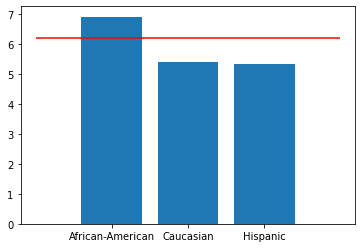

In [58]:
# Representamos dichos valores para compararlos en un diagrama de barras, pintando el umbral de riesgo para todo el dataframe como referencia

plt.bar(dict_race.keys(), dict_race.values())
plt.hlines(umbral_riesgo_delito(historiales), xmin=-1, xmax=3, color='red')

Los resultados son bastante llamativos. Para el grupo de los afroamericanos (barra azul), el umbral de riesgo está claramente por encima que para el conjunto de individuos estudiados (línea roja).
La puntuación a partir de la cual los afroamericanos deberían presentar un riesgo, basándonos en datos reales de reincidencia, es claramente superior a la puntuación para el resto de individuos, y hay aún más diferencia si comparamos la puntuación de los afroamericanos con los de otras razas.
Hay por lo tanto un sesgo en contra de los afroamericanos, y a favor de los caucásicos y los hispanos. Los que tienen un umbral de riesgo por encima de la media (afroamericanos) están teniendo puntuaciones demasiado altas. Justo lo contrario para caucásicos e hispanos.

Repetimos el análisis, pero esta vez enfocándonos en los delitos violentos

In [59]:
# Adaptamos las funciones anteriores para que usen los datos relativos a delitos violentos

def v_umbral_riesgo_delito(df):
    tasa_reincidencia = df['two_year_violent_recid'].mean()
    listofscores = df['v_decile_score'].sort_values().to_list()
    posicion_en_lista = round(len(listofscores)*(1-tasa_reincidencia)-1) 
    decil_entero = listofscores[int(round(posicion_en_lista))]
    valor_umbral = ((posicion_en_lista - listofscores.index(decil_entero))/(listofscores.index(decil_entero+1) - listofscores.index(decil_entero)))+decil_entero
    return valor_umbral

In [60]:
# Calculamos el umbral de riesgo en nuestro dataframe, para delitos violentos
v_umbral_riesgo_delito(historiales)

8.624

In [61]:
def v_umbral_riesgo_cat(df,col,cat):
    tasa_reincidencia = df[df[col] == cat]['two_year_violent_recid'].mean()
    listofscores = df[df[col] == cat]['v_decile_score'].sort_values().to_list()
    posicion_en_lista = round(len(listofscores)*(1-tasa_reincidencia)-1)
    decil_entero = listofscores[int(round(posicion_en_lista))]
    valor_umbral = ((posicion_en_lista - listofscores.index(decil_entero))/(listofscores.index(decil_entero+1) - listofscores.index(decil_entero)))+decil_entero
    return valor_umbral

In [62]:
# Llamamos a la función para cada una de las razas escogidas

v_dict_race= {}
for element in top_races:
    v_dict_race[element]=v_umbral_riesgo_cat(historiales,'race',element)
v_dict_race

{'African-American': 8.932642487046632,
 'Caucasian': 7.657534246575342,
 'Hispanic': 8.642857142857142}

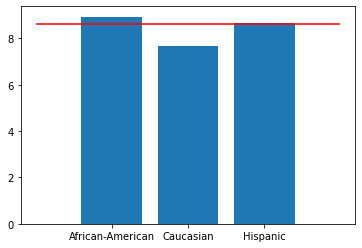

In [63]:
# Representamos dichos valores para compararlos en un diagrama de barras, pintando el umbral de riesgo para todo el dataframe como referencia

plt.bar(v_dict_race.keys(), v_dict_race.values())
plt.hlines(v_umbral_riesgo_delito(historiales), xmin=-1, xmax=3, color='red')

# Nuevamente hay un ligero sesgo en contra de los afroamericanos y a favor de los caucásicos, pero esta vez no hay sesgo a favor de los hispanos

Y ahora hacemos el mismo análisis comparativo para hombres y mujeres

In [64]:
dict_sex = {}
for element in historiales['sex'].unique():
    dict_sex[element]=umbral_riesgo_cat(historiales,'sex',element)
dict_sex

{'Male': 6.144607843137255, 'Female': 6.373831775700935}

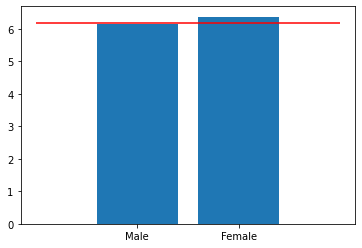

In [65]:
plt.bar(dict_sex.keys(), dict_sex.values())
plt.hlines(umbral_riesgo_delito(historiales), xmin=-1, xmax=2, color='red')

# En este caso, hay un ligero sesgo en contra de las mujeres

In [66]:
# Para delitos violentos:

v_dict_sex = {}
for element in historiales['sex'].unique():
    v_dict_sex[element]=v_umbral_riesgo_cat(historiales,'sex',element)
v_dict_sex

{'Male': 8.72072072072072, 'Female': 7.9}

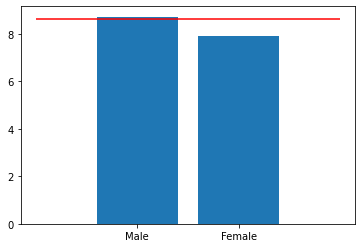

In [67]:
plt.bar(v_dict_sex.keys(), v_dict_sex.values())
plt.hlines(v_umbral_riesgo_delito(historiales), xmin=-1, xmax=2, color='red')

# Sesgo en contra de los hombres y a favor de las mujeres

Llama la atención que los sesgos son diferentes dependiendo de si estamos considerando delitos sin violencia o con violencia. Vamos a comprobar los valores de "tasa_reincidencia" que utilizábamos en las funciones umbral_riesgo, para ver qué obtenemos.

In [68]:
# Para delitos no violentos: calculamos la tasa de reincidencia, tanto la general, como la correspondiente al conjunto de hombres y al conjunto de mujeres

print('Tasa de reincidencia general: ', historiales['two_year_recid'].mean())
print('Tasa de reincidencia para hombres: ', historiales[historiales['sex'] == 'Male']['two_year_recid'].mean())
print('Tasa de reincidencia para mujeres: ', historiales[historiales['sex'] == 'Female']['two_year_recid'].mean())

Tasa de reincidencia general:  0.3324013157894737
Tasa de reincidencia para hombres:  0.35245404968693195
Tasa de reincidencia para mujeres:  0.24446412754650132


In [69]:
# Lo mismo para delitos violentos

print('Tasa de reincidencia general: ', historiales['two_year_violent_recid'].mean())
print('Tasa de reincidencia para hombres: ', historiales[historiales['sex'] == 'Male']['two_year_violent_recid'].mean())
print('Tasa de reincidencia para mujeres: ', historiales[historiales['sex'] == 'Female']['two_year_violent_recid'].mean())

Tasa de reincidencia general:  0.07171052631578947
Tasa de reincidencia para hombres:  0.07715613007473238
Tasa de reincidencia para mujeres:  0.047829937998228524


Vemos que, para los delitos no violentos, la tasa de reincidencia está en un valor más "centrado" (más alejado del 0 y del 1) que para los delitos violentos.
Probablemente, el tipo de transformación matemática que hemos hecho para calcular los umbrales de riesgo sea más sensible a errores cuando, al tener una tasa de reincidencia muy baja, se busca en los valores más extremos de las puntuaciones COMPAS.

## Punto 5
**¿Para qué tipo de riesgos, el de delitos generales o el de delitos violentos, tiene el sistema más capacidad predictiva?**

### AUC ROC
En el punto 3, definimos un clasificador binario (will_recid) en función de si las puntuaciones COMPAS (decile_score) sobrepasaban un determinado umbral.

Para este tipo de clasificadores, como ya se hizo en el caso práctico 1 de la unidad 5 (desarrollar un clasificador de imágenes de 0s y 1s), se puede utilizar la curva ROC y la medida del área bajo la curva (AUC ROC) para determinar cómo de eficaz es el clasificador.

In [70]:
# Calculamos el AUC ROC para el clasificador de delitos "estándar": 'decile_score'

from sklearn.metrics import roc_auc_score

roc_auc_score(historiales['two_year_recid'] == 1 , historiales['decile_score'])

0.6740741675330928

In [71]:
# Calculamos el AUC ROC para el clasificador de delitos violentos: 'v_decile_score'

roc_auc_score(historiales['two_year_violent_recid'] == 1 , historiales['v_decile_score'])

0.6507176168245568

Se ve que, en este caso, el clasificador para delitos no violentos es ligeramente mejor que el clasificador de delitos violentos, aunque tienen valores bastante similares

### Análisis contextual
Como complemento para responder a la pregunta, vamos a poner en contexto los conceptos teóricos estudiados acerca de los clasificadores, y vamos a ver cómo nos pueden ayudar en este caso concreto que estamos estudiando: un sistema para la predicción de personas potencialmente reincidentes.

Intentaré responder una pregunta que me he hecho a mí mismo: **¿si yo fuese el responsable de decidir cómo usar los resultados del modelo, qué haría?** Además, tratando de responder a esta pregunta, podremos seguir indagando acerca de la pregunta hecha en el enunciado: para qué tipo de riesgos tiene el sistema más capacidad predictiva.

_NOTA: esto lo hago simplemente "como excusa" para seguir haciendo exploraciones y sacando conclusiones acerca de los datos y los modelos que hemos usado en el caso práctico. Evidentemente, si fuese el responsable real de tomar decisiones acerca de esto, haría análisis muchísimo más profundos y cuidadoso, siendo como es este un tema tan delicado._

Dicho esto, vamos a calcular las tablas de contigencia y los indicadores, jugando con la puntuación COMPAS que establecemos como umbral para considerar que el individuo va a reincidir, todo ello para las puntuaciones tanto de delitos no violentos como violentos.

In [72]:
# La tabla de contigencia y los indicadores los vamos a calcular utilizando una función.
# Esta función utiliza un código similar al utilizado para responder al Punto 3.

def tabla_contingencia(nombre_col_decile, nombre_col_recid, umbral): 
    prediccion_recid = np.where(historiales[nombre_col_decile] >= umbral, 1, 0)
    prediccion_recid = prediccion_recid.astype('int64')
    tcont = pd.crosstab(prediccion_recid, historiales[nombre_col_recid])
    tcont = tcont.reindex([1,0],columns=[1,0])
    tcont = tcont.rename_axis("Predicción", axis="index").rename_axis("Realidad", axis="columns")
    
    # Para esta tabla de contigencia, calculamos los indicadores
    sensibilidad = tcont[1][1]/(tcont[1][1]+tcont[1][0])
    especifididad = tcont[0][0]/(tcont[0][0]+tcont[0][1])
    exactitud = (tcont[1][1]+tcont[0][0])/tcont.sum().sum()
    
    return tcont, sensibilidad, especifididad, exactitud

In [73]:
# PARA DELITOS NO VIOLENTOS: calculamos el valor de los indicadores para cada valor de la puntuación COMPAS utilizado como umbral

for decile in range(2,11):
    tcont, sensibilidad, especifididad, exactitud = tabla_contingencia('decile_score', 'two_year_recid', decile)
    print(f'Para decile {decile} SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: {sensibilidad:.3f}, {especifididad:.3f}, {exactitud:.3f}')

Para decile 2 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.900, 0.277, 0.484
Para decile 3 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.810, 0.430, 0.556
Para decile 4 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.715, 0.542, 0.599
Para decile 5 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.611, 0.645, 0.634
Para decile 6 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.518, 0.735, 0.663
Para decile 7 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.405, 0.806, 0.673
Para decile 8 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.297, 0.874, 0.682
Para decile 9 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.191, 0.920, 0.678
Para decile 10 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.082, 0.969, 0.674


In [74]:
# PARA DELITOS VIOLENTOS

for decile in range(2,11):
    tcont, sensibilidad, especifididad, exactitud = tabla_contingencia('v_decile_score', 'two_year_violent_recid', decile)
    print(f'Para decile {decile} SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: {sensibilidad:.3f}, {especifididad:.3f}, {exactitud:.3f}')

Para decile 2 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.862, 0.291, 0.332
Para decile 3 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.780, 0.443, 0.467
Para decile 4 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.638, 0.574, 0.579
Para decile 5 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.525, 0.682, 0.671
Para decile 6 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.433, 0.774, 0.750
Para decile 7 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.317, 0.853, 0.814
Para decile 8 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.220, 0.912, 0.862
Para decile 9 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.131, 0.949, 0.891
Para decile 10 SENSIBILIDAD, ESPECIFICIDAD, EXACTITUD: 0.037, 0.984, 0.916


PARA DELITOS VIOLENTOS:

¿Qué valor usaría yo como umbral para establecer medidas preventivas? Vamos a buscar un clasificador que tenga una exactitud alta (es decir, que acierte, "que no cometa injusticias"), pero también le vamos a dar bastante importancia al hecho de que el sistema tenga bastante sensibilidad (porque me interesa establecer medidas preventivas que afecten al individuo, pero que puedan evitar que cometa un crimen grave)

Teniendo esto en mente, creo que para delitos VIOLENTOS establecería el umbral en 6, creo que balancea bien una proporción alta de predicciones acertadas con una proporción moderada de potenciales reincidentes que el sistema detecta.

PARA DELITOS NO VIOLENTOS:

En este caso le daría una importancia capital a que el sistema tenga una exactitud alta, y en menor medida que la especificidad sea alta (es decir, que no tome medidas preventivas que afecten al individuo, para evitar un crimen que no es grave)

Teniendo esto en mente, para delitos NO VIOLENTOS establecería el umbral en 9.